In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Creates the sqlalchemy engine and uses a SQL query to store the data in a dataframe
engine = create_engine('sqlite:///mta.db')
turnstiles_df = pd.read_sql('SELECT * FROM mta_data;', engine)

In [20]:
turnstiles_df['DATE'] = turnstiles_df['DATE'].astype('datetime64[ns]')
turnstiles_df['STATION_LINE'] = turnstiles_df.STATION + ", " + turnstiles_df.LINENAME
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7325278 entries, 0 to 7325277
Data columns (total 12 columns):
 #   Column        Dtype         
---  ------        -----         
 0   CA            object        
 1   UNIT          object        
 2   SCP           object        
 3   STATION       object        
 4   LINENAME      object        
 5   DIVISION      object        
 6   DATE          datetime64[ns]
 7   TIME          object        
 8   DESC          object        
 9   ENTRIES       int64         
 10  EXITS         int64         
 11  STATION_LINE  object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 670.6+ MB


,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION_LINE
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,03:00:00,REGULAR,7508509,2557569,"59 ST, NQR456W"
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,07:00:00,REGULAR,7508511,2557581,"59 ST, NQR456W"
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,11:00:00,REGULAR,7508531,2557636,"59 ST, NQR456W"
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,15:00:00,REGULAR,7508610,2557667,"59 ST, NQR456W"
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,19:00:00,REGULAR,7508767,2557689,"59 ST, NQR456W"
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,23:00:00,REGULAR,7508852,2557704,"59 ST, NQR456W"
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-27,03:00:00,REGULAR,7508858,2557705,"59 ST, NQR456W"
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-27,07:00:00,REGULAR,7508862,2557711,"59 ST, NQR456W"
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-27,11:00:00,REGULAR,7508885,2557743,"59 ST, NQR456W"
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-27,15:00:00,REGULAR,7508955,2557778,"59 ST, NQR456W"


In [4]:
turnstiles_daily = (turnstiles_df
                        .groupby(["CA", "UNIT", "SCP", "STATION_LINE", "DATE"],as_index=False)
                        .ENTRIES.first())

turnstiles_hourly = turnstiles_df.copy()
turnstiles_hourly = turnstiles_hourly[turnstiles_hourly.TIME.isin(['00:00:00','04:00:00','08:00:00','12:00:00','16:00:00','20:00:00','24:00:00'])]

turnstiles_hourly['HOURLY_AMT'] = turnstiles_hourly.groupby(["CA", "UNIT", "SCP", "STATION_LINE"]).ENTRIES.diff()
turnstiles_hourly[turnstiles_hourly.STATION_LINE =='34 ST-HERALD SQ, BDFMNQRW'].head(20)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION_LINE,HOURLY_AMT
2306562,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-14,04:00:00,REGULAR,28753647,12153782,"34 ST-HERALD SQ, BDFMNQRW",NaN
2306563,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-14,08:00:00,REGULAR,28753660,12153821,"34 ST-HERALD SQ, BDFMNQRW",13.0
2306564,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-14,12:00:00,REGULAR,28753722,12153908,"34 ST-HERALD SQ, BDFMNQRW",62.0
2306565,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-14,16:00:00,REGULAR,28753884,12154107,"34 ST-HERALD SQ, BDFMNQRW",162.0
2306566,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-14,20:00:00,REGULAR,28754076,12154287,"34 ST-HERALD SQ, BDFMNQRW",192.0
2306567,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-15,00:00:00,REGULAR,28754157,12154346,"34 ST-HERALD SQ, BDFMNQRW",81.0
2306568,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-15,04:00:00,REGULAR,28754162,12154349,"34 ST-HERALD SQ, BDFMNQRW",5.0
2306569,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-15,08:00:00,REGULAR,28754190,12154476,"34 ST-HERALD SQ, BDFMNQRW",28.0
2306570,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-15,12:00:00,REGULAR,28754323,12154810,"34 ST-HERALD SQ, BDFMNQRW",133.0
2306571,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-15,16:00:00,REGULAR,28754591,12154995,"34 ST-HERALD SQ, BDFMNQRW",268.0


In [5]:
turnstiles_daily['DAILY_TOT'] = turnstiles_daily.groupby(["CA", "UNIT", "SCP", "STATION_LINE"]).ENTRIES.diff()
turnstiles_daily['DAILY_TOT_ABS'] = np.absolute(turnstiles_daily.DAILY_TOT)

turnstiles_hourly['HOURLY_AMT_ABS'] = np.absolute(turnstiles_hourly.HOURLY_AMT)

In [6]:
mask = (turnstiles_daily.DAILY_TOT_ABS < 15000)
maskh = (turnstiles_hourly.HOURLY_AMT_ABS < 2000)
turnstiles_daily_cleaned = turnstiles_daily[mask]
turnstiles_hourly_cleaned = turnstiles_hourly[maskh]
mask_shift = (turnstiles_daily.SCP.shift(1) != turnstiles_daily.SCP)
#turnstiles_daily['DAILY_TOT'][mask_shift] = np.nan
#turnstiles_daily.loc[mask_shift,'DAILY_TOT'] = np.nan
#turnstiles_daily[(turnstiles_daily.STATION == 'HEWES ST') & (turnstiles_daily.SCP == '00-00-00')]


In [23]:
station_daily = turnstiles_daily_cleaned.groupby(['STATION_LINE','DATE'])[['DAILY_TOT_ABS']].sum().reset_index()
station_daily_sum = station_daily.groupby('STATION_LINE').DAILY_TOT_ABS.sum().reset_index().sort_values('DAILY_TOT_ABS',ascending = False).head(15)
station_daily_sum['STATION'] = station_daily_sum.STATION_LINE.apply(lambda x: x[:x.find(',')])

station_hourly = turnstiles_hourly_cleaned.groupby(['STATION_LINE','TIME'])[['HOURLY_AMT_ABS']].mean().reset_index()

top_list = station_daily_sum.STATION_LINE.head(5).to_list()

,STATION_LINE,DAILY_TOT_ABS,STATION
89,"34 ST-HERALD SQ, BDFMNQRW",6874390.0,34 ST-HERALD SQ
312,"GRD CNTRL-42 ST, 4567S",6075330.0,GRD CNTRL-42 ST
102,"42 ST-PORT AUTH, ACENQRS1237W",5323705.0,42 ST-PORT AUTH
289,"FLUSHING-MAIN, 7",5007988.0,FLUSHING-MAIN
339,"JKSN HT-ROOSVLT, EFMR7",4623119.0,JKSN HT-ROOSVLT


Text(0.5, 1.0, 'Total Sum of Entries by Station (02-06-2021-05-29-2021)')

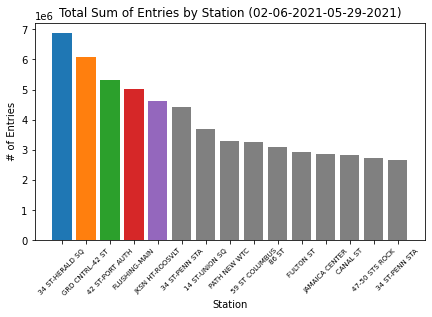

In [9]:
color_lst = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey']
plt.figure(figsize=(7,4))

plt.bar(station_daily_sum.STATION_LINE, station_daily_sum.DAILY_TOT_ABS, tick_label = station_daily_sum.STATION, color = color_lst)
plt.ylabel('# of Entries')
plt.xlabel('Station')
plt.xticks(rotation=45, size = 7)
plt.title('Total Sum of Entries by Station (02-06-2021-05-29-2021)')


In [10]:
daily_by_station = (turnstiles_daily_cleaned
                    .groupby(['STATION_LINE','DATE'])
                    .DAILY_TOT_ABS.sum().reset_index())

station_hourly_top = station_hourly[station_hourly.STATION_LINE.isin(top_list)].reset_index()

top_list = station_daily_sum.STATION_LINE.head(5).to_list()
top_station_mask = daily_by_station['STATION_LINE'].isin(top_list)

daily_by_station_top = daily_by_station[top_station_mask].reset_index()

station_daily_sum.sort_values(['DAILY_TOT_ABS'], ascending = False)

station_hourly_top.sort_values(by = ['HOURLY_AMT_ABS'], ascending = False).head(20)

,index,STATION_LINE,TIME,HOURLY_AMT_ABS
27,1961,"JKSN HT-ROOSVLT, EFMR7",12:00:00,253.198475
15,1673,"FLUSHING-MAIN, 7",12:00:00,229.591051
5,515,"34 ST-HERALD SQ, BDFMNQRW",20:00:00,224.952608
28,1962,"JKSN HT-ROOSVLT, EFMR7",16:00:00,206.845903
17,1675,"FLUSHING-MAIN, 7",20:00:00,202.165824
29,1963,"JKSN HT-ROOSVLT, EFMR7",20:00:00,184.099836
16,1674,"FLUSHING-MAIN, 7",16:00:00,179.201780
26,1960,"JKSN HT-ROOSVLT, EFMR7",08:00:00,177.895588
14,1672,"FLUSHING-MAIN, 7",08:00:00,175.169234
9,579,"42 ST-PORT AUTH, ACENQRS1237W",12:00:00,153.095408


In [11]:
daily_by_station_top.head(20)

,index,STATION_LINE,DATE,DAILY_TOT_ABS
0,21707,"34 ST-HERALD SQ, BDFMNQRW",2020-12-27,19336.0
1,21708,"34 ST-HERALD SQ, BDFMNQRW",2020-12-28,15624.0
2,21709,"34 ST-HERALD SQ, BDFMNQRW",2020-12-29,28942.0
3,21710,"34 ST-HERALD SQ, BDFMNQRW",2020-12-30,29745.0
4,21711,"34 ST-HERALD SQ, BDFMNQRW",2020-12-31,29922.0
5,21712,"34 ST-HERALD SQ, BDFMNQRW",2021-01-01,23229.0
6,21713,"34 ST-HERALD SQ, BDFMNQRW",2021-01-02,10660.0
7,21714,"34 ST-HERALD SQ, BDFMNQRW",2021-01-03,19096.0
8,21715,"34 ST-HERALD SQ, BDFMNQRW",2021-01-04,11437.0
9,21716,"34 ST-HERALD SQ, BDFMNQRW",2021-01-05,26242.0


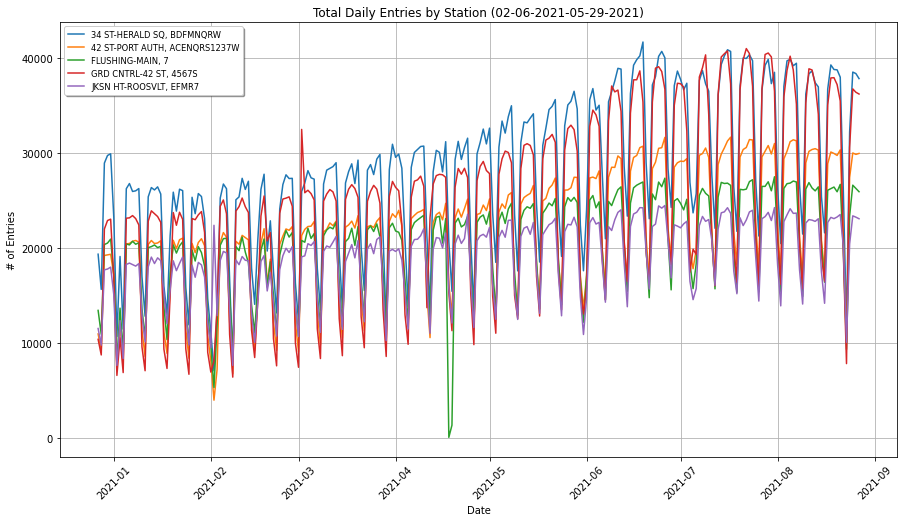

In [12]:
plt.figure(figsize=(15,8))
plt.grid() 
for i, group in daily_by_station_top.groupby('STATION_LINE'):
    plt.plot(group['DATE'], group['DAILY_TOT_ABS'], label = i)

plt.legend(shadow = True, loc = 0, fontsize = 'small')
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Total Daily Entries by Station (02-06-2021-05-29-2021)')

plt.savefig('figs/daily_entries_by_station.png', bbox_inches = 'tight')

In [13]:
daily_by_station_top['DAY_OF_WEEK_NUM'] = pd.to_datetime(daily_by_station_top['DATE']).dt.dayofweek
daily_by_station_top

,index,STATION_LINE,DATE,DAILY_TOT_ABS,DAY_OF_WEEK_NUM
0,21707,"34 ST-HERALD SQ, BDFMNQRW",2020-12-27,19336.0,6
1,21708,"34 ST-HERALD SQ, BDFMNQRW",2020-12-28,15624.0,0
2,21709,"34 ST-HERALD SQ, BDFMNQRW",2020-12-29,28942.0,1
3,21710,"34 ST-HERALD SQ, BDFMNQRW",2020-12-30,29745.0,2
4,21711,"34 ST-HERALD SQ, BDFMNQRW",2020-12-31,29922.0,3
...,...,...,...,...,...
1215,82932,"JKSN HT-ROOSVLT, EFMR7",2021-08-23,10047.0,0
1216,82933,"JKSN HT-ROOSVLT, EFMR7",2021-08-24,20421.0,1
1217,82934,"JKSN HT-ROOSVLT, EFMR7",2021-08-25,23380.0,2
1218,82935,"JKSN HT-ROOSVLT, EFMR7",2021-08-26,23241.0,3


In [14]:
daily_by_station_dow_mean = daily_by_station_top.groupby(['STATION_LINE','DAY_OF_WEEK_NUM']).DAILY_TOT_ABS.mean().reset_index()
daily_by_station_dow_mean.head()

,STATION_LINE,DAY_OF_WEEK_NUM,DAILY_TOT_ABS
0,"34 ST-HERALD SQ, BDFMNQRW",0,16603.085714
1,"34 ST-HERALD SQ, BDFMNQRW",1,29406.457143
2,"34 ST-HERALD SQ, BDFMNQRW",2,32119.314286
3,"34 ST-HERALD SQ, BDFMNQRW",3,32764.828571
4,"34 ST-HERALD SQ, BDFMNQRW",4,32246.971429


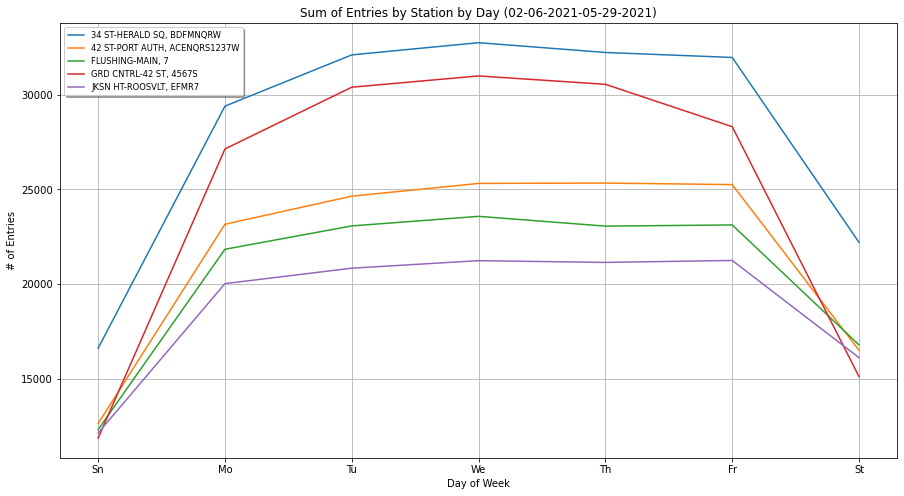

In [15]:
plt.figure(figsize=(15,8))
plt.grid() 
for i, group in daily_by_station_dow_mean.groupby('STATION_LINE'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_TOT_ABS'], label = i)
    
plt.legend(shadow = True, loc = 0, fontsize = 'small')

plt.ylabel('# of Entries')
plt.xlabel('Day of Week')
plt.xticks(np.arange(7),['Sn','Mo','Tu','We','Th','Fr','St'])
plt.title('Sum of Entries by Station by Day (02-06-2021-05-29-2021)')


<ipython-input-16-2bdd9f5e80a3>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['','Sn','Mo','Tu','We','Th','Fr','St'])


<Figure size 1080x1080 with 0 Axes>

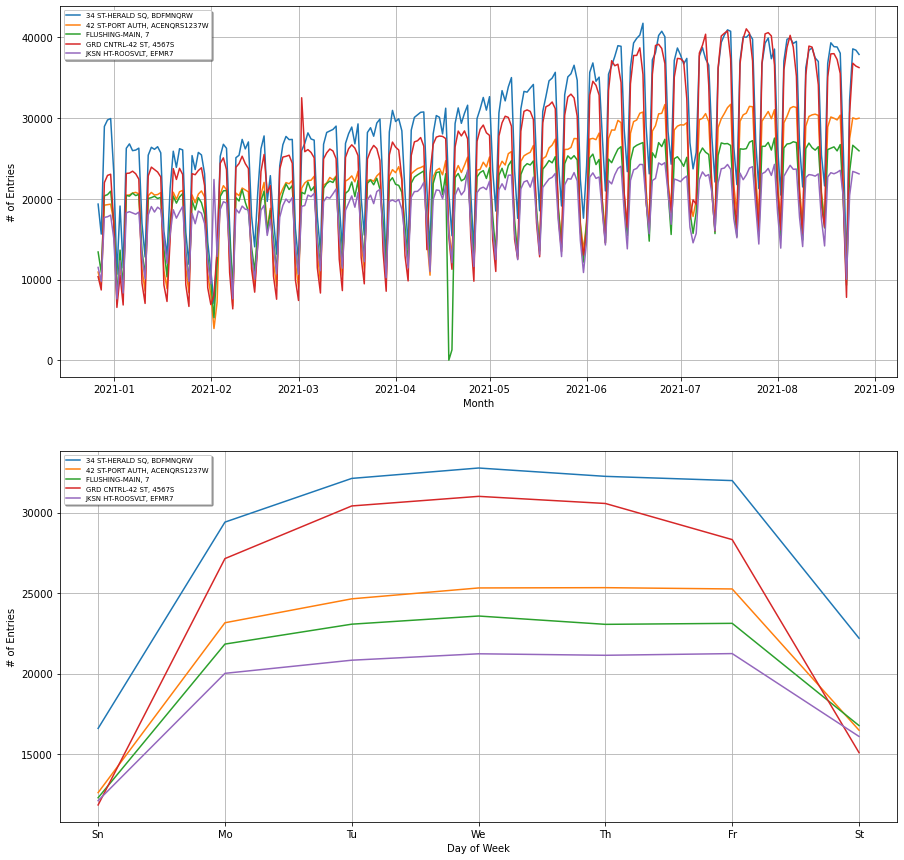

In [16]:
plt.figure(figsize=(15,15))
fig, (ax1,ax2) = plt.subplots(2, figsize = (15,15))
ax2.grid() 
for i, group in daily_by_station_dow_mean.groupby('STATION_LINE'):
    ax2.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_TOT_ABS'], label = i)
    
ax2.legend(shadow = True, loc = 0, fontsize = 'x-small')
ax2.set(xlabel = 'Day of Week', ylabel = '# of Entries')
ax2.set_xticklabels(['','Sn','Mo','Tu','We','Th','Fr','St'])
# ax1.ylabel('# of Entries')
# ax1.xlabel('Day of Week')
# 
# ax1.title('Sum of Entries by Station by Day (02-06-2021-05-29-2021)')
ax1.grid()
for i, group in daily_by_station_top.groupby('STATION_LINE'):
    ax1.plot(group['DATE'], group['DAILY_TOT_ABS'], label = i)

ax1.legend(shadow = True, loc = 0, fontsize = 'x-small')
ax1.set(xlabel = 'Month', ylabel = '# of Entries')
# ax2.ylabel('# of Entries')
# ax2.xlabel('Date')
# ax2.xticks(rotation=45)
# ax2.title('Total Daily Entries by Station (02-06-2021-05-29-2021)')

plt.savefig('figs/fig_subplot.png', bbox_inches = 'tight')

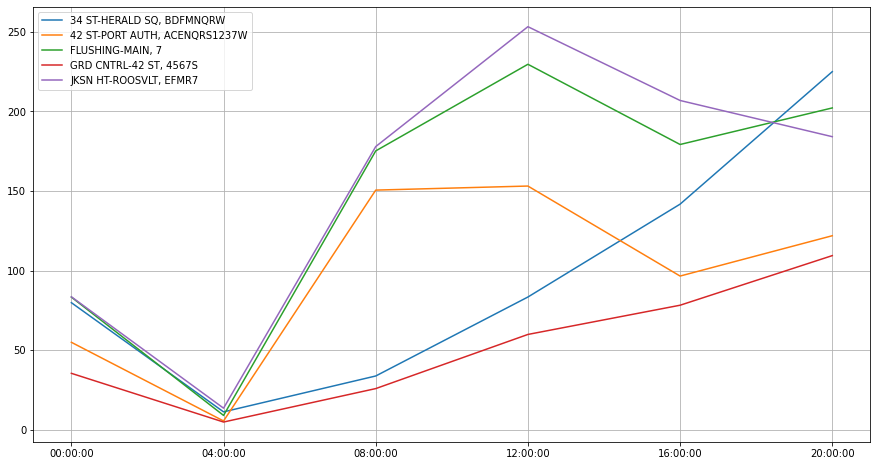

In [17]:
plt.figure(figsize=(15,8))
plt.grid()
for i, group in station_hourly_top.groupby('STATION_LINE'):
    plt.plot(group['TIME'],group['HOURLY_AMT_ABS'], label = i)
plt.legend()

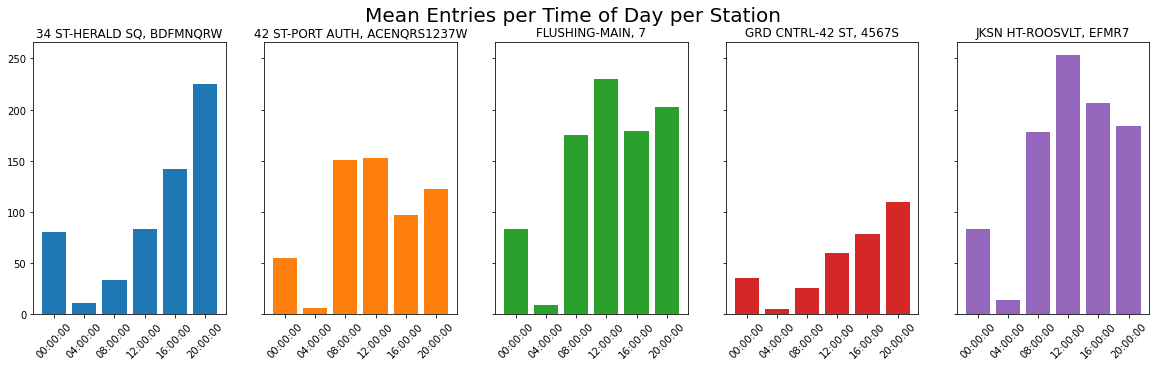

In [18]:
fig, axs = plt.subplots(1,5, figsize=(20,5), sharey = 'row')
fig.suptitle('Mean Entries per Time of Day per Station', size = 20)
idx = 0
for i, group in station_hourly_top.groupby('STATION_LINE'):
    axs[idx].bar(group['TIME'],group['HOURLY_AMT_ABS'], label = i, color = color_lst[idx])
    axs[idx].set_title(i)
    axs[idx].tick_params('x',labelrotation = 45)
    idx+=1